In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import os

# Spectrum Bounds Analysis

In [2]:
def add_theory_band(ax, experiments, min_lambda=None):
    """
    Add theoretical slope band (ε ∝ 1/√(m/d_λ)) to an axis.

    Args:
        ax: Matplotlib axis
        experiments: List of experiment dictionaries with 'm_over_d_lambda' and 'empirical_eps_95'
        min_lambda: Optional minimum lambda threshold to filter experiments
    """
    # Filter experiments if threshold is specified
    filtered_experiments = [e for e in experiments if min_lambda is None or e["lambda"] >= min_lambda]
    all_m_ratio = np.array([e["m_over_d_lambda"] for e in filtered_experiments])
    all_eps = np.array([e["empirical_eps_95"] for e in filtered_experiments])
    mask = np.isfinite(all_m_ratio) & np.isfinite(all_eps) & (all_m_ratio > 0) & (all_eps > 0)
    x_clean, y_clean = all_m_ratio[mask], all_eps[mask]

    if len(x_clean) > 0:
        x_theory = np.logspace(np.log10(x_clean.min()), np.log10(x_clean.max()), 100)
        # Show band of theoretical lines with different constants
        C_med = np.median(y_clean * np.sqrt(x_clean))
        # More lines with wider spread for better visualization
        factors = np.logspace(np.log10(0.000001), np.log10(1000000), 50)
        for factor in factors:
            # Fade alpha towards edges
            dist_from_center = abs(np.log10(factor))
            alpha = 0.18 * np.exp(-0.15 * dist_from_center)
            y_theory = (C_med * factor) / np.sqrt(x_theory)
            ax.loglog(x_theory, y_theory, 'k-', alpha=alpha, linewidth=0.8)
        # Add the main reference line
        ax.loglog(x_theory, C_med / np.sqrt(x_theory), 'k--', linewidth=2, alpha=0.7)

        # Store info for annotation (will be added after layout)
        ax._theory_annotation_info = {
            'C_med': C_med,
            'x_theory': x_theory,
        }


def add_theory_annotations(fig, axes):
    """Add annotations with correct slope after figure layout is finalized."""
    # Need to draw first to get accurate transforms
    fig.canvas.draw()

    for ax in axes.flat:
        if not hasattr(ax, '_theory_annotation_info'):
            continue

        info = ax._theory_annotation_info
        C_med = info['C_med']
        x_theory = info['x_theory']

        # Get current axis limits
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # The line y = C/sqrt(x) exits the visible region at one of two points:
        # 1. Bottom exit: where y = ylim[0], giving x = (C/ylim[0])^2
        # 2. Right exit: where x = xlim[1], giving y = C/sqrt(xlim[1])
        #
        # We place the annotation at whichever exit is within the visible region.

        x_at_bottom = (C_med / ylim[0]) ** 2  # x where line hits y_min
        y_at_right = C_med / np.sqrt(xlim[1])  # y where line hits x_max

        if x_at_bottom <= xlim[1]:
            # Line exits at bottom - place annotation near bottom
            annot_y = ylim[0] * 3  # slightly above bottom
            annot_x = (C_med / annot_y) ** 2
        else:
            # Line exits at right - place annotation near right edge
            annot_x = xlim[1] / 20  # slightly left of right edge
            annot_y = C_med / np.sqrt(annot_x)

        # Compute angle in display coordinates
        # Take two points on the line and transform to display coords
        x1, x2 = x_theory[50], x_theory[70]
        y1 = C_med / np.sqrt(x1)
        y2 = C_med / np.sqrt(x2)

        # Transform data coordinates to display coordinates
        disp1 = ax.transData.transform((x1, y1))
        disp2 = ax.transData.transform((x2, y2))

        # Compute angle from display coordinates
        dx = disp2[0] - disp1[0]
        dy = disp2[1] - disp1[1]
        angle_deg = np.degrees(np.arctan2(dy, dx))

        # Add annotation close to the line with small offset
        ax.annotate(r'$\varepsilon \propto 1/\sqrt{m/d_\lambda}$',
                    xy=(annot_x, annot_y), fontsize=16,
                    ha='center', va='bottom',
                    xytext=(0, 3),  # small offset above the line
                    textcoords='offset points',
                    rotation=angle_deg,
                    rotation_mode='anchor')


# Define a unified set of lambda values and colors for consistent plotting
# Extended to include both smaller lambdas (10^{-8}, 10^{-7}) and larger lambdas (10^1, 10^2)
UNIFIED_LAMBDA_VALUES = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
UNIFIED_LAMBDA_COLORS = {lamb: plt.cm.viridis(i / (len(UNIFIED_LAMBDA_VALUES) - 1))
                          for i, lamb in enumerate(UNIFIED_LAMBDA_VALUES)}


def get_lambda_color(lamb, lambda_colors=None):
    """Get color for a lambda value, using unified colors if available."""
    if lambda_colors is not None and lamb in lambda_colors:
        return lambda_colors[lamb]
    # Fallback: find closest lambda in unified set
    if UNIFIED_LAMBDA_COLORS:
        closest = min(UNIFIED_LAMBDA_VALUES, key=lambda x: abs(np.log10(x) - np.log10(lamb)) if lamb > 0 else float('inf'))
        return UNIFIED_LAMBDA_COLORS[closest]
    return 'blue'


def create_lambda_colorbar(lambda_values=None, save_path=None, figsize=(8, 1.2), fontsize=28):
    """
    Create a standalone horizontal colorbar for lambda values.

    Args:
        lambda_values: List of lambda values to include (default: UNIFIED_LAMBDA_VALUES)
        save_path: Path to save the colorbar figure
        figsize: Figure size (width, height)
        fontsize: Font size for colorbar label and ticks

    Returns:
        fig: The colorbar figure
    """
    from matplotlib.colors import LogNorm
    from matplotlib.cm import ScalarMappable

    if lambda_values is None:
        lambda_values = UNIFIED_LAMBDA_VALUES

    lambda_min = min(lambda_values)
    lambda_max = max(lambda_values)

    fig, ax = plt.subplots(figsize=figsize)

    # Create colorbar using viridis colormap with log normalization
    cmap = plt.cm.viridis
    norm = LogNorm(vmin=lambda_min, vmax=lambda_max)
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = plt.colorbar(sm, cax=ax, orientation='horizontal')
    cbar.ax.set_ylabel('$\\lambda$', fontsize=fontsize+10, weight='bold', rotation=0, labelpad=30, y=0.0)
    cbar.ax.tick_params(labelsize=fontsize-2)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved colorbar to {save_path}")

    plt.show()
    return fig


In [3]:
def plot_bilinear_form_error_combined(configs, proj_type="sjlt", results_dir="./results/spectrum_bounds",
                                       min_lambda=None, ci_alpha=0.2,
                                       figsize=(20, 5), save_path=None, lambda_colors=None, wspace=0.2, sharey=False):
    """
    Plot bilinear form error for multiple dataset-model configs in a single figure.

    Confidence intervals are automatically shown when multiple trials are available.

    Args:
        configs: List of (dataset, model) tuples
        proj_type: Projection type (default: "sjlt")
        results_dir: Directory containing results
        min_lambda: Minimum lambda threshold to filter experiments
        ci_alpha: Alpha for confidence interval shading
        figsize: Figure size (width, height)
        save_path: Path to save the combined figure
        lambda_colors: Dict mapping lambda -> color
        wspace: Width space between subplots (default: 0.15)
        sharey: Whether to share y-axis across subplots (default: False)

    Returns:
        fig: The combined figure
    """
    n_plots = len(configs)
    fig, axes = plt.subplots(1, n_plots, figsize=figsize, sharey=sharey)

    if n_plots == 1:
        axes = [axes]

    if lambda_colors is None:
        lambda_colors = UNIFIED_LAMBDA_COLORS

    # Display names for consistent formatting
    display_names = {
        ('mnist', 'lr'): 'MNIST + LR',
        ('mnist', 'mlp'): 'MNIST + MLP',
        ('cifar2', 'resnet9'): 'CIFAR-2 + ResNet9'
    }

    for idx, (dataset, model) in enumerate(configs):
        ax = axes[idx]
        test_path = f"{results_dir}/{dataset}_{model}_{proj_type}_test.pt"

        if not os.path.exists(test_path):
            print(f"Test mode results not found: {test_path}")
            ax.text(0.5, 0.5, 'Data not found', ha='center', va='center', transform=ax.transAxes)
            continue

        test_results = torch.load(test_path, map_location="cpu", weights_only=False)
        print(f"Loaded test mode results for {dataset}/{model}")

        # Check for per-trial data - always show CI when available
        has_per_trial = (len(test_results['experiments']) > 0 and
                         'empirical_eps_95_std' in test_results['experiments'][0])

        if has_per_trial:
            num_trials = test_results.get('num_trials', 5)
            t_value = 1.96 if num_trials > 30 else {2: 12.71, 3: 4.30, 4: 3.18, 5: 2.78,
                                                      6: 2.57, 7: 2.45, 8: 2.36, 9: 2.31,
                                                      10: 2.26}.get(num_trials, 2.0)

        lambda_values = test_results["lambda_values"]
        if min_lambda is not None:
            lambda_values = [l for l in lambda_values if l >= min_lambda]

        # Organize by lambda
        test_by_lambda = {}
        for exp in test_results["experiments"]:
            lamb = exp["lambda"]
            if min_lambda is not None and lamb < min_lambda:
                continue
            if lamb not in test_by_lambda:
                test_by_lambda[lamb] = []
            test_by_lambda[lamb].append(exp)

        ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, alpha=0.8)

        all_y_test = []
        for lamb in sorted(lambda_values):
            if lamb not in test_by_lambda:
                continue
            color = get_lambda_color(lamb, lambda_colors)
            exps = sorted(test_by_lambda[lamb], key=lambda x: x["m_over_d_lambda"])
            x = np.array([e["m_over_d_lambda"] for e in exps])
            y = np.array([e["empirical_eps_95"] for e in exps])
            all_y_test.extend(y)

            ax.loglog(x, y, 'o-', color=color, markersize=6, alpha=0.8)

            # Always show CI when multiple trials available
            if has_per_trial:
                y_std = np.array([e.get("empirical_eps_95_std", 0) for e in exps])
                n_trials = np.array([e.get("n_trials", num_trials) for e in exps])
                y_se = y_std / np.sqrt(n_trials)
                y_ci = t_value * y_se
                y_lower = np.maximum(y - y_ci, y * 0.01)
                y_upper = y + y_ci
                ax.fill_between(x, y_lower, y_upper, color=color, alpha=ci_alpha)

        add_theory_band(ax, test_results["experiments"], min_lambda)

        # Only set ylim if sharey is False (let matplotlib auto-scale when independent)
        if not sharey and all_y_test:
            ax.set_ylim(min(all_y_test) * 0.5, max(all_y_test) * 2.0)

        # Format y-axis to use scientific notation (10^{-x})
        from matplotlib.ticker import LogFormatterSciNotation
        ax.yaxis.set_major_formatter(LogFormatterSciNotation())

        # Use display name if available, otherwise fallback to uppercase
        title = display_names.get((dataset, model), f'{dataset.upper()} + {model.upper()}')
        ax.set_title(title, fontsize=24)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_xlabel('$m / d_\\lambda$', fontsize=28)

    # Add shared y-label on the left
    axes[0].set_ylabel(r"$_{95\%}\, \varepsilon_{\lambda}$", fontsize=28)


    plt.tight_layout()
    plt.subplots_adjust(wspace=wspace)

    # Add theory annotations after layout
    add_theory_annotations(fig, np.array(axes))

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved combined figure to {save_path}")

    plt.show()
    return fig


def plot_spectrum_combined(configs, proj_type="sjlt", results_dir="./results/spectrum_bounds",
                           figsize=(20, 5), save_path=None, linewidth=3.5, wspace=0.2, sharey=False):
    """
    Plot eigenvalue spectrum for multiple dataset-model configs in a single figure.

    Args:
        configs: List of (dataset, model) tuples
        proj_type: Projection type (default: "sjlt")
        results_dir: Directory containing results
        figsize: Figure size (width, height)
        save_path: Path to save the combined figure
        linewidth: Width of the spectrum line
        wspace: Width space between subplots (default: 0.15)
        sharey: Whether to share y-axis across subplots (default: False for independent scaling)

    Returns:
        fig: The combined figure
    """
    n_plots = len(configs)
    fig, axes = plt.subplots(1, n_plots, figsize=figsize, sharey=sharey)

    if n_plots == 1:
        axes = [axes]

    # Display names for consistent formatting
    display_names = {
        ('mnist', 'lr'): 'MNIST + LR',
        ('mnist', 'mlp'): 'MNIST + MLP',
        ('cifar2', 'resnet9'): 'CIFAR-2 + ResNet9'
    }

    for idx, (dataset, model) in enumerate(configs):
        ax = axes[idx]
        self_path = f"{results_dir}/{dataset}_{model}_{proj_type}_self.pt"

        if not os.path.exists(self_path):
            print(f"Self-influence results not found: {self_path}")
            ax.text(0.5, 0.5, 'Data not found', ha='center', va='center', transform=ax.transAxes)
            continue

        self_results = torch.load(self_path, map_location="cpu", weights_only=False)
        print(f"Loaded self-influence results for {dataset}/{model}")

        eigenvalues = self_results.get("eigenvalues")
        rank = self_results.get("rank", len(eigenvalues) if eigenvalues is not None else 0)

        if eigenvalues is not None:
            ax.semilogy(eigenvalues[:rank], 'b-', linewidth=linewidth)
            ax.set_xlabel('$i$', fontsize=28)
            ax.tick_params(axis='both', which='major', labelsize=20)
            # Use display name if available, otherwise fallback to uppercase
            title = display_names.get((dataset, model), f'{dataset.upper()} + {model.upper()}')
            ax.set_title(title, fontsize=24)
        else:
            ax.text(0.5, 0.5, 'Eigenvalues not available',
                    ha='center', va='center', transform=ax.transAxes)
            # Use display name if available, otherwise fallback to uppercase
            title = display_names.get((dataset, model), f'{dataset.upper()} + {model.upper()}')
            ax.set_title(title, fontsize=24)

    # Add shared y-label on the left
    axes[0].set_ylabel('$\\lambda_i$', fontsize=28)


    plt.tight_layout()
    plt.subplots_adjust(wspace=wspace)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved combined figure to {save_path}")

    plt.show()
    return fig

Plotting Combined Bilinear Form Error
Loaded test mode results for mnist/lr
Loaded test mode results for mnist/mlp
Loaded test mode results for cifar2/resnet9
Saved combined figure to ./figures/spectrum_bounds/bilinear_combined.pdf


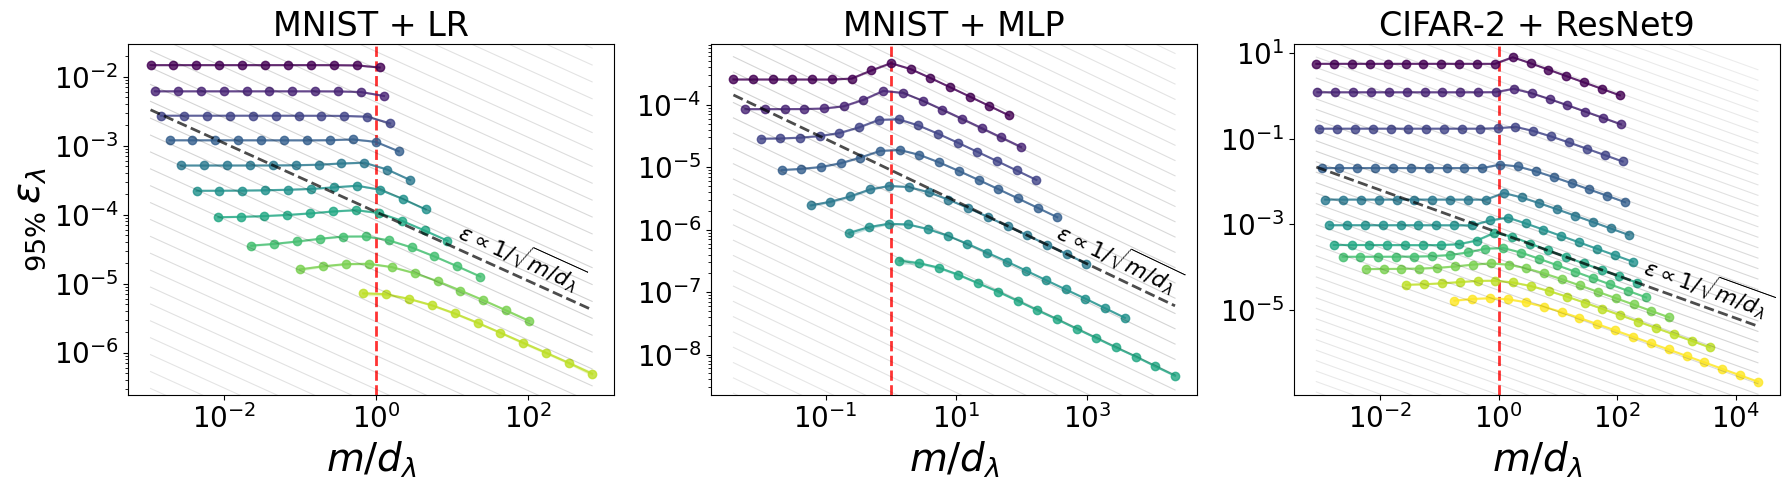


Generating Lambda Colorbar
Saved colorbar to ./figures/spectrum_bounds/lambda_colorbar.pdf


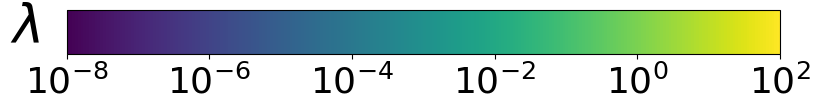


Plotting Combined Eigenvalue Spectrum
Loaded self-influence results for mnist/lr
Loaded self-influence results for mnist/mlp
Loaded self-influence results for cifar2/resnet9
Saved combined figure to ./figures/spectrum_bounds/spectrum_combined.pdf


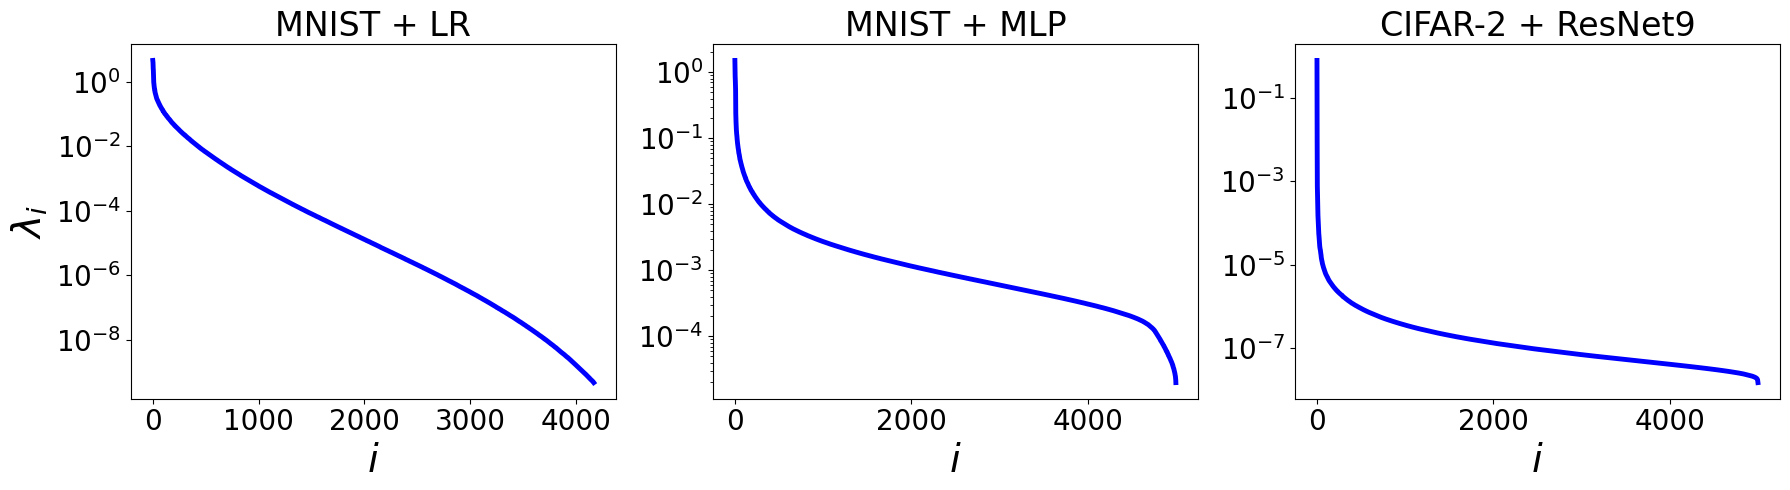

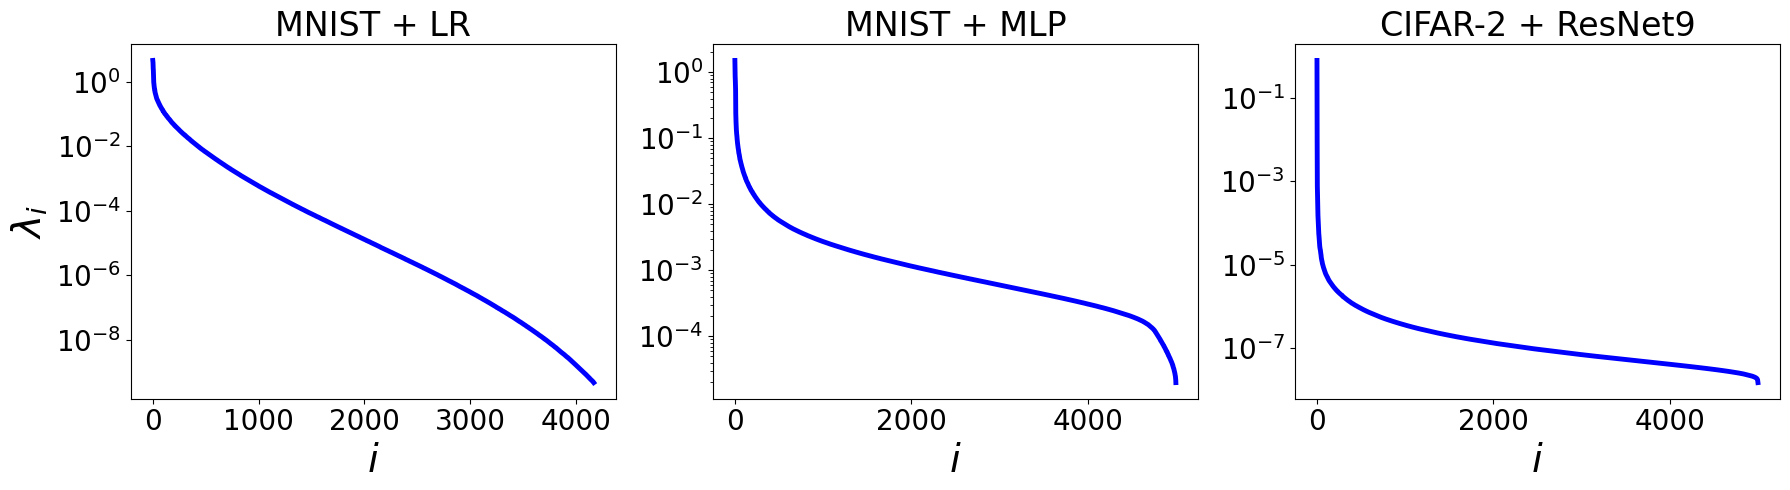

In [4]:
# =============================================================================
# Plot Combined Figures for Paper
# =============================================================================

spectrum_configs = [
    ("mnist", "lr"),
    ("mnist", "mlp"),
    ("cifar2", "resnet9"),
]

figures_dir = "./figures"
os.makedirs(figures_dir, exist_ok=True)
os.makedirs(f"{figures_dir}/spectrum_bounds", exist_ok=True)

# Combined bilinear form error plot (all 3 datasets side-by-side)
print("=" * 60)
print("Plotting Combined Bilinear Form Error")
print("=" * 60)
bilinear_combined_path = f"{figures_dir}/spectrum_bounds/bilinear_combined.pdf"
plot_bilinear_form_error_combined(spectrum_configs, save_path=bilinear_combined_path,
                                   figsize=(18, 5), lambda_colors=UNIFIED_LAMBDA_COLORS)

# Generate unified legend for the combined plot
print("\n" + "=" * 60)
print("Generating Lambda Colorbar")
print("=" * 60)
colorbar_path = f"{figures_dir}/spectrum_bounds/lambda_colorbar.pdf"
create_lambda_colorbar(save_path=colorbar_path, figsize=(8, 1.2), fontsize=28)

# Combined spectrum plot (all 3 datasets side-by-side)
print("\n" + "=" * 60)
print("Plotting Combined Eigenvalue Spectrum")
print("=" * 60)
spectrum_combined_path = f"{figures_dir}/spectrum_bounds/spectrum_combined.pdf"
plot_spectrum_combined(spectrum_configs, save_path=spectrum_combined_path, figsize=(18, 5))